## Intro 
In this notebook we will apply knowledge gathered from previous analysis to kegg ortologs, this dataset is focused on even lower level biounits than bacteria famillies and pathways, and thus we have much more features, this means we can utilise 1D CNN networks in order to try to reduce number of parameters in the model, We have to remember that CNN try to find structural patterns and we dont necccesarily have ones in our dataset as positioning of columns is random. Nevertheless we decided to test this approach   

### Import libraries and load data

In [86]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
# for tensorboard logs
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, SMOTEN
from keras.layers import Dense, Dropout, Activation, Flatten
import xgboost as xgb
np.random.seed(111)
tf.random.set_seed(111)


In [32]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/H2O_based/Data/H2O_KEGG_ortholog_merged.csv')
print(df.shape)
df.head()

(73, 6539)


,timepoint,pond,ID,sample_id,K00001,K00002,K00003,K00004,K00005,K00006,...,K18325,K18471,K18699,K18920,K18921,K18922,K19056,K19234,K19238,K19688
0,0,S08,126,126.0,0.064180,0.000000,0.209235,0.000000,0.201688,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,S08,127,127.0,0.208505,0.000000,0.328480,0.152997,0.450738,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,S08,128,128.0,0.181197,0.198464,0.317529,0.157512,0.221801,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,S14,129,129.0,0.464626,1.000000,0.306387,0.112867,0.266124,0.277778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,S14,130,130.0,0.244841,0.023047,0.131934,0.076248,0.042274,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


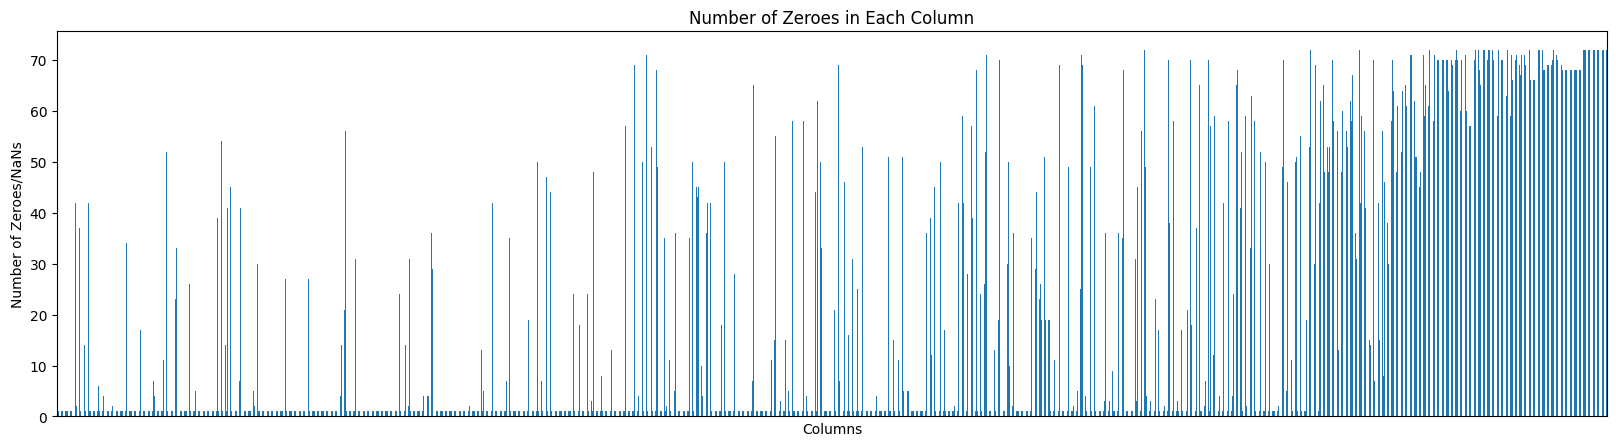

In [33]:
zero_counts = ((df == 0) | (df.isna())).sum()
zero_counts.plot(kind='bar', figsize=(20, 5))
plt.xlabel('Columns')
plt.ylabel('Number of Zeroes/NaNs')
plt.title('Number of Zeroes in Each Column')
plt.xticks([])
plt.show()

We have similar missing observations distribution as for bacteria familly dataset.

In [34]:
df.drop('sample_id', axis=1, inplace=True)

In [35]:
predictors = df.columns[3:]
print("number of predictors: ", len(predictors))

number of predictors:  6535


In [36]:
df[df['pond'] == "S29"]

,timepoint,pond,ID,K00001,K00002,K00003,K00004,K00005,K00006,K00007,...,K18325,K18471,K18699,K18920,K18921,K18922,K19056,K19234,K19238,K19688
11,1,S29,139,0.333501,0.020487,0.18221,0.633057,0.132410,0.160819,0.181166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2,S29,140,0.260365,0.000000,0.14964,0.231252,0.187907,0.105263,0.242369,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
df[df['pond'] == "S18"]

,timepoint,pond,ID,K00001,K00002,K00003,K00004,K00005,K00006,K00007,...,K18325,K18471,K18699,K18920,K18921,K18922,K19056,K19234,K19238,K19688
6,1,S18,133,0.14259,0.0,0.084755,0.320542,0.031845,0.0,0.137550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2,S18,134,0.00000,0.0,0.007353,0.034362,0.760507,0.0,0.033993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df.fillna(0, inplace=True)

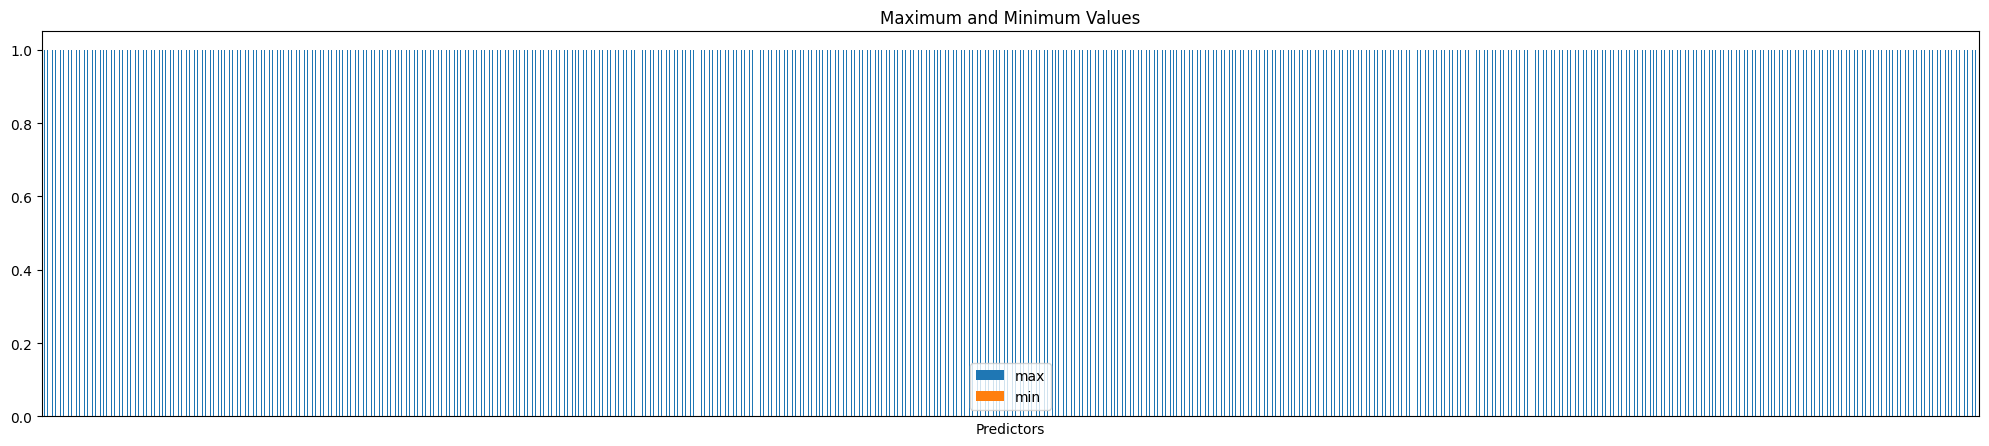

In [39]:
max_values = df[predictors].max()
min_values = df[predictors].min()


max_min_df = pd.DataFrame({'max': max_values, 'min': min_values})
max_min_df.plot(kind='bar', figsize=(25, 5))
plt.title('Maximum and Minimum Values')
plt.xlabel('Predictors')
plt.xticks([])
plt.show()

As the dataset was normalized before using standard scaler there is no needd to do that 



| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [40]:
df['pond_org'] = df['pond']

In [ ]:
# Decoding use pond decoder 2 for this

def pond_decoder(x,codes):
   
    x=x.replace('S','')
    num = int(x)
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}
codes3 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32], 2 : [9,13,17,20,27,11,15,22,25,31]}


df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))
df['class_pond3'] = df['pond'].apply(lambda x: pond_decoder(x,codes3))


In [47]:
# defragmenting 
df = df.copy()

In [49]:
df['pondXtime'] = df['class_pond'].astype(str) + "_" + df['timepoint'].astype(str)
df['pondXtime_3'] = df['class_pond3'].astype(str) + "_" + df['timepoint'].astype(str)

In [51]:
le = LabelEncoder()
le3 = LabelEncoder()
df['pondXtime'] = le.fit_transform(df['pondXtime'])
df['pondXtime_3'] = le3.fit_transform(df['pondXtime_3'])
df['pondXtime'].value_counts()
df['pondXtime_3'].value_counts()

pondXtime_3
3    10
4    10
5    10
6    10
7    10
8    10
1     5
2     5
0     3
Name: count, dtype: int64

In [53]:
train_val_df, test_df = train_test_split(df, test_size= 0.2, random_state=111, stratify=df['pondXtime'])
print(train_val_df.shape, test_df.shape)

(58, 6543) (15, 6543)


### Definitions

In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [55]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=100,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

### Modeling timepoints
First thing that we are going to try is the only thing that worked properly wchich is modeling timepoints only.

In [58]:
model0 = keras.Sequential()
model0.add(keras.layers.Dense(1024,input_shape=(len(predictors),),activation='relu'))
model0.add(keras.layers.Dense(254, activation ='relu'))
model0.add(keras.layers.Dropout(rate=0.25))
model0.add(keras.layers.Dense(128, activation ='relu'))

model0.add(keras.layers.Dense(64, activation ='relu'))
model0.add(keras.layers.Dense(16, activation ='relu'))
model0.add(keras.layers.Dropout(rate=0.25))
model0.add(keras.layers.Dense(16, activation ='relu'))

model0.add(keras.layers.Dense(3, activation ='softmax'))

print(model0.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model0.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 1024)           │     6,692,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,995,473 (26.69 MB)

 Trainable params: 6,995,473 (26.69 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9333 - loss: 0.8172
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted classes:       [2 2 2 1 1 1 0 1 2 1 0 1 0 1 2]
true validation classes: [2 2 2 1 1 1 2 1 2 1 0 1 0 1 2]
mean confidence score: 3.0027966086739226e+17, sd confidence score: 1.1163681992785801e+18
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 5.5631e-08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
predicted classes:       [0 1 0 0 0 2 2 0 0 1 0 1 0 0 1]
true validation classes: [0 1 0 0 0 2 2 0 0 1 0 1 0 0 1]
mean confidence score: 2.6690818601084475e+27, sd confidence score: 9.986789821032987e+27
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predicted classes:       [1 1 1 2 1 2 1 2 1 2 1 0 2 1 2]
true validation classes: [1 1 1 2 1 2 1 2 1 2 1 0 2 1 2]
mean confidence score: 1.9191998640666298e+17, sd confi

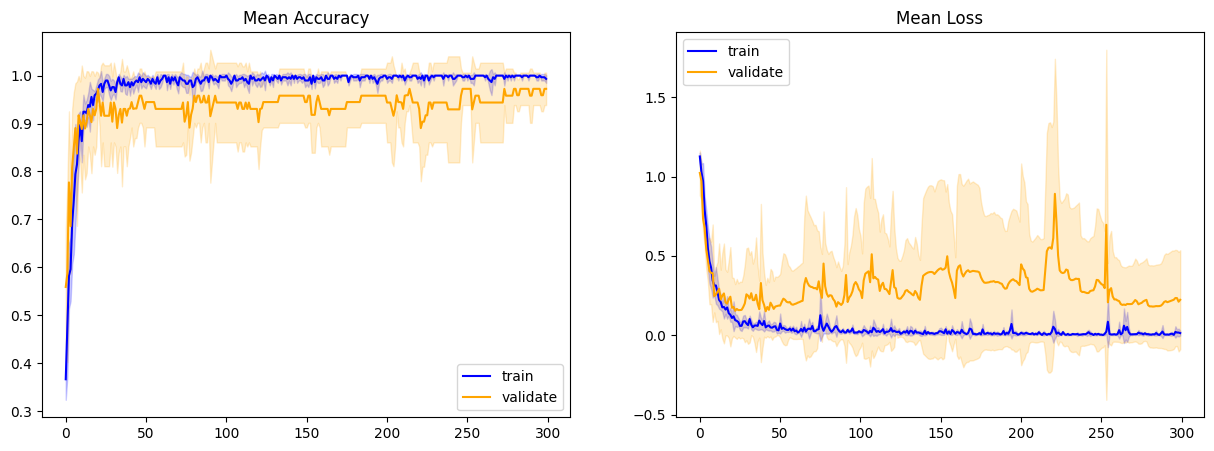

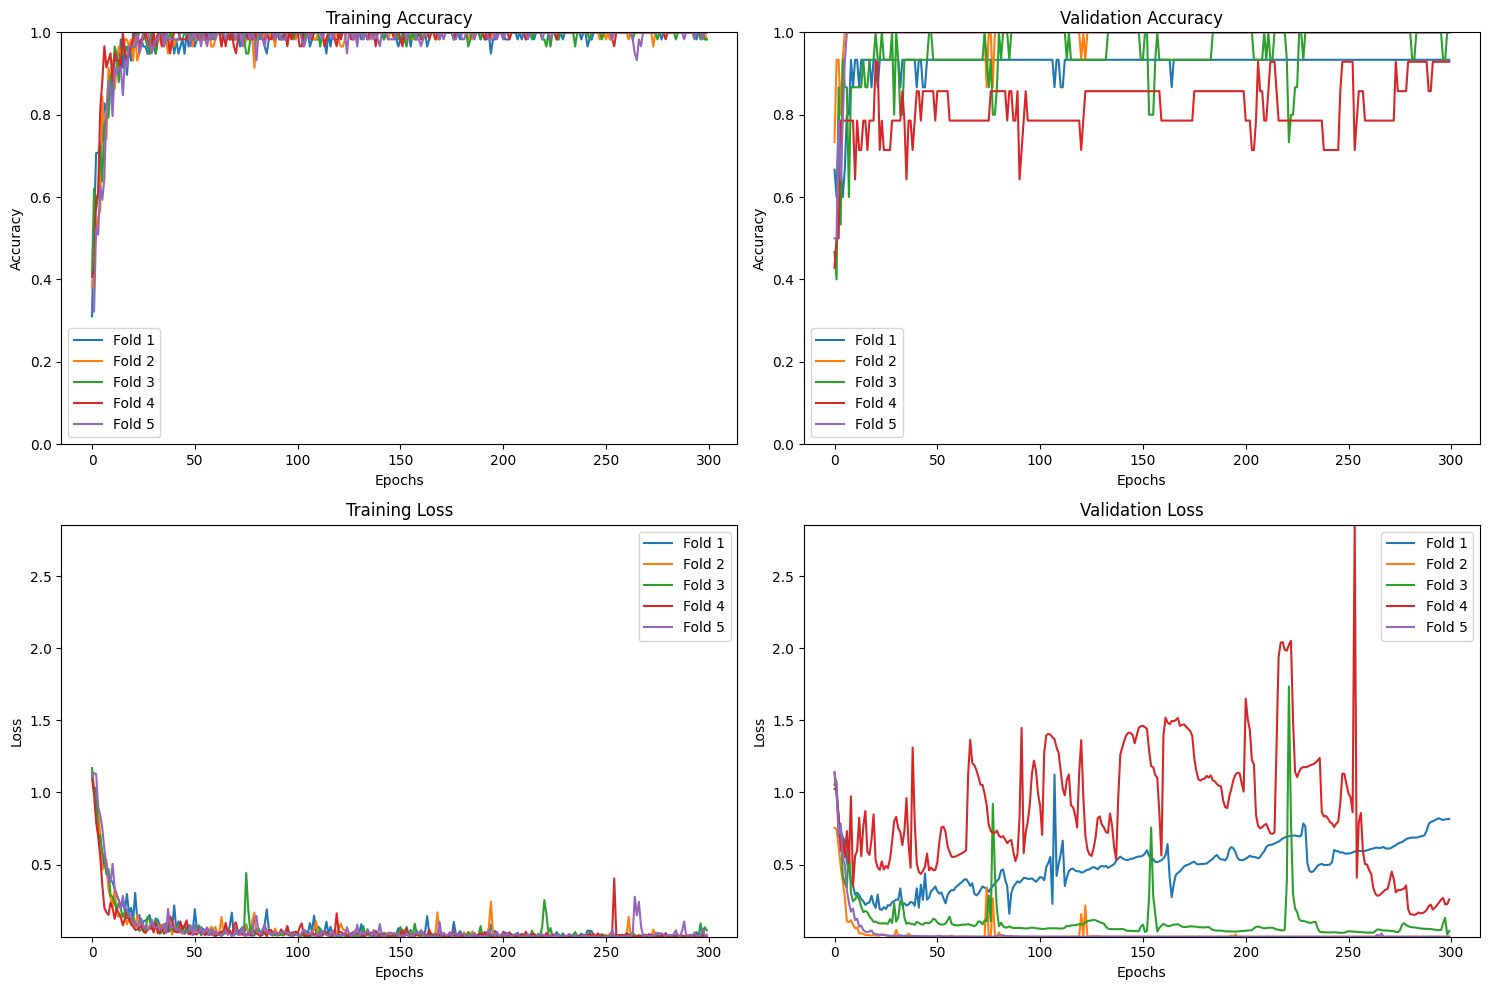

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted classes:       [2 0 2 2 1 0 2 0 0 0 1 2 2 2]
true validation classes: [2 0 2 2 1 0 2 0 0 0 1 2 2 2]


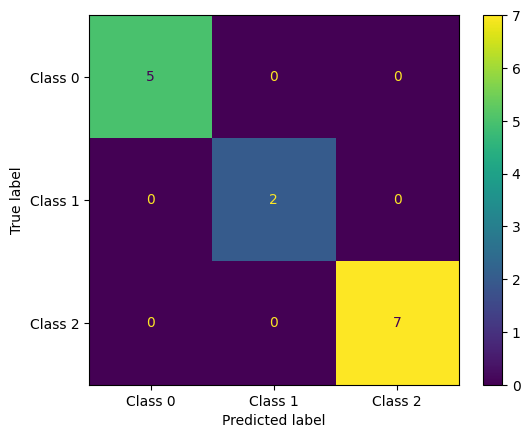

In [59]:
crossvalidate(df, model0, predictors, 'timepoint', kf)

As we can see for KO dataset it worked perfectly as well, the model is much bigger and thus the loss functions are fluctuating much more but we have very nice accuracy.

In [61]:
model0c = keras.Sequential()

model0c.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model0c.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model0c.add(Flatten())

model0c.add(keras.layers.Dense(1024, activation ='relu'))
model0c.add(keras.layers.Dense(254, activation ='relu'))
model0c.add(keras.layers.Dropout(rate=0.25))

model0c.add(keras.layers.Dense(128, activation ='relu'))

model0c.add(keras.layers.Dense(64, activation ='relu'))
model0c.add(keras.layers.Dense(16, activation ='relu'))
model0c.add(keras.layers.Dropout(rate=0.25))
model0c.add(keras.layers.Dense(16, activation ='relu'))

model0c.add(keras.layers.Dense(3, activation ='softmax'))

print(model0c.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model0c.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 6531, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 6529, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13058)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │    13,372,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,675,063 (52.17 MB)

 Trainable params: 13,675,063 (52.17 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 3
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9333 - loss: 0.9964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
predicted classes:       [2 2 2 1 1 1 0 1 2 1 0 1 0 1 2]
true validation classes: [2 2 2 1 1 1 2 1 2 1 0 1 0 1 2]
mean confidence score: 1695749049445.2312, sd confidence score: 5574733091538.209
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 5.9629e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted classes:       [0 1 0 0 0 2 2 0 0 1 0 1 0 0 1]
true validation classes: [0 1 0 0 0 2 2 0 0 1 0 1 0 0 1]
mean confidence score: 104691112720438.03, sd confidence score: 281438475750667.06
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9333 - loss: 0.2384
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted classes:       [1 1 1 2 1 2 1 2 0 2 1 0 2 1 2]
true validation classes: [1 1 1 2 1 2 1 2 1 2 1 0 2 1 2]
mean confidence score: 570571043166048.1, sd confidence score: 17289075

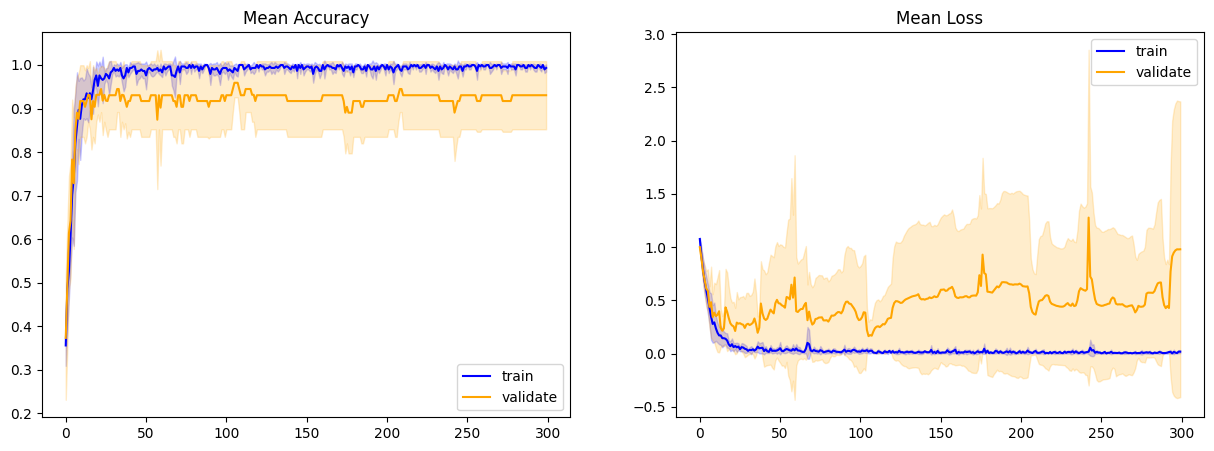

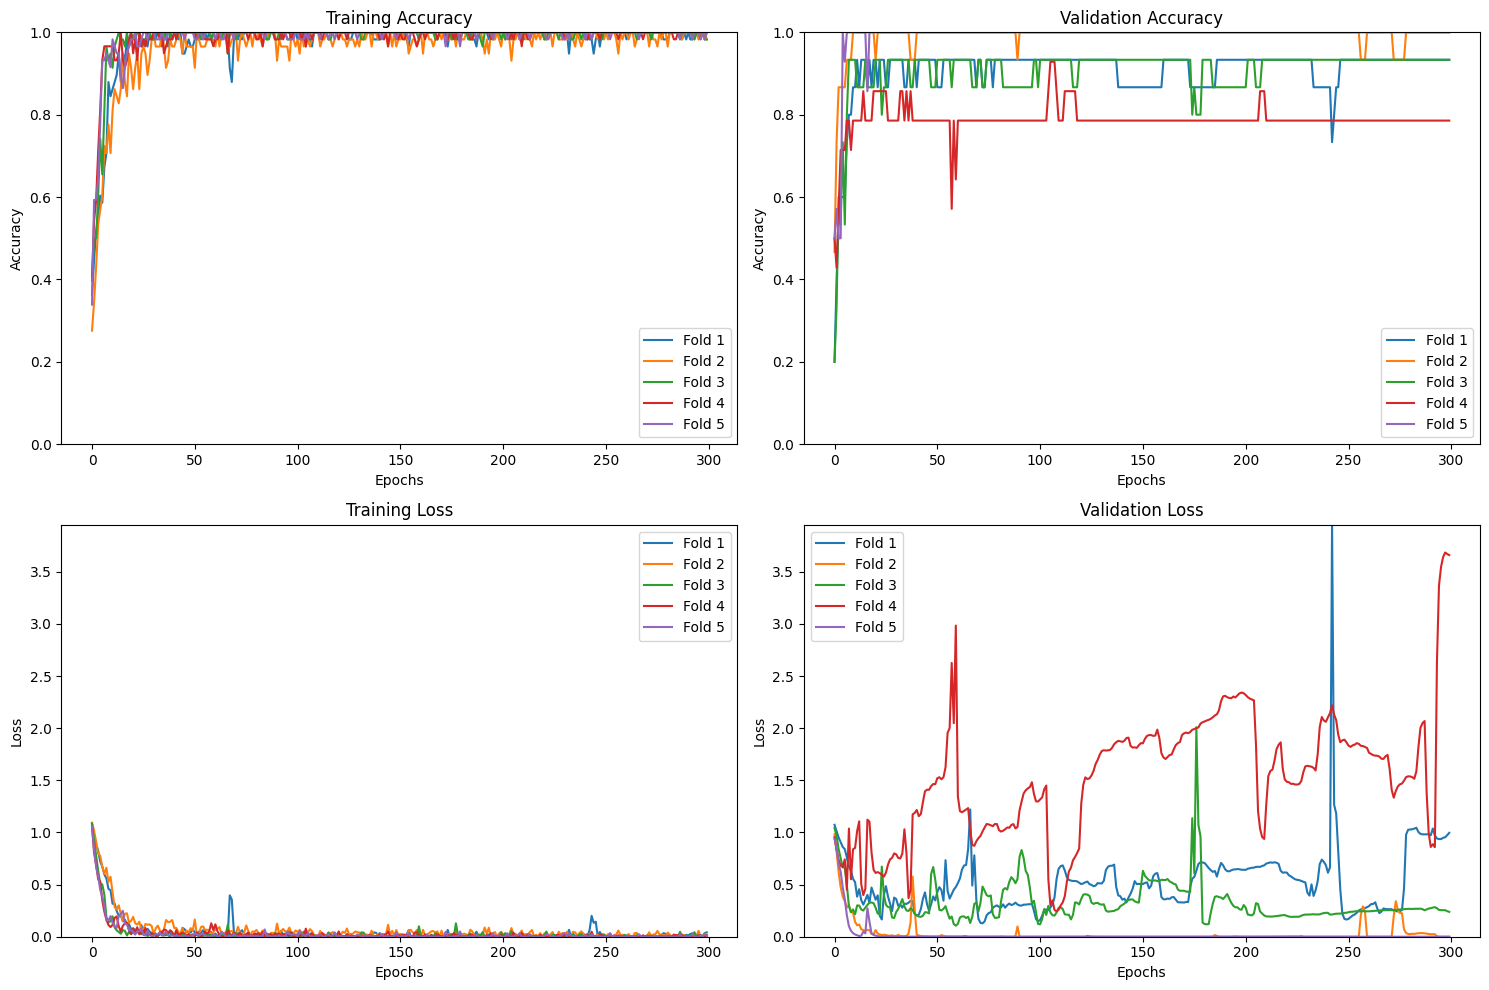

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
predicted classes:       [2 0 2 2 1 0 2 0 0 0 1 2 2 2]
true validation classes: [2 0 2 2 1 0 2 0 0 0 1 2 2 2]


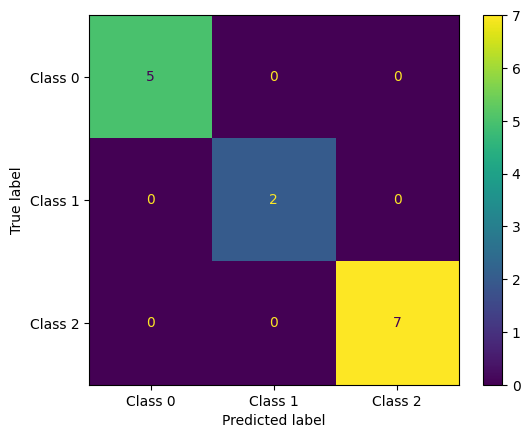

In [62]:
crossvalidate(df, model0c, predictors, 'timepoint', kf)

Convolutional approach proved to yield same results as non convolutional having very good accuracy for all the folds.

### Convolution only ponds

In [65]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv1D(filters=3, kernel_size=5, activation='relu',input_shape = (len(predictors),1)))
model2.add(keras.layers.Conv1D(filters=2, kernel_size=3, activation='relu'))


model2.add(Flatten())

model2.add(keras.layers.Dense(1024, activation ='relu'))
model2.add(keras.layers.Dense(254, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))

model2.add(keras.layers.Dense(128, activation ='relu'))

model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dense(16, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

print(model2.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 6531, 3)        │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 6529, 2)        │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 13058)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │    13,372,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 254)            │       260,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 254)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,675,097 (52.17 MB)

 Trainable params: 13,675,097 (52.17 MB)

 Non-trainable params: 0 (0.00 B)

None


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.5333 - loss: 5.2552
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
predicted classes:       [0 1 0 1 0 2 4 2 2 0 3 3 4 2 2]
true validation classes: [0 1 1 1 1 1 2 2 2 3 3 3 4 4 4]
mean confidence score: 2712185.6054, sd confidence score: 9858355.596
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2667 - loss: 9.3107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted classes:       [0 2 2 4 2 2 3 2 3 1 2 2 2 2 2]
true validation classes: [0 0 0 1 1 2 3 3 3 3 3 4 4 4 4]
mean confidence score: 8163467114.3424, sd confidence score: 28357346488.1797
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1333 - loss: 7.9532
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted classes:       [0 1 3 4 4 0 0 1 1 1 4 4 1 3 1]
true validation classes: [0 0 1 1 2 2 2 2 3 3 3 4 4 4 4]
mean confidence score: 1048023.5273, sd confidence score: 3492054.765
training for 4 subset


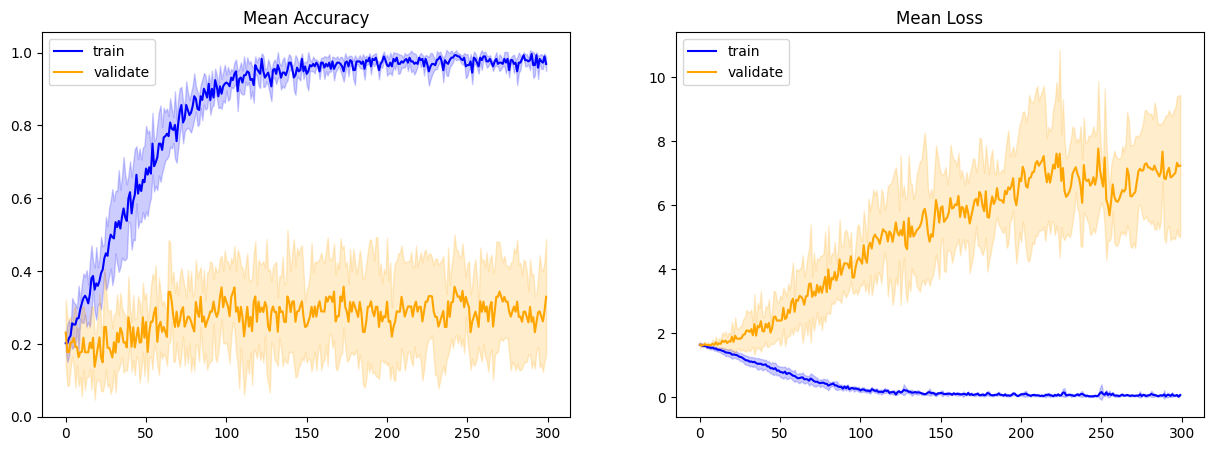

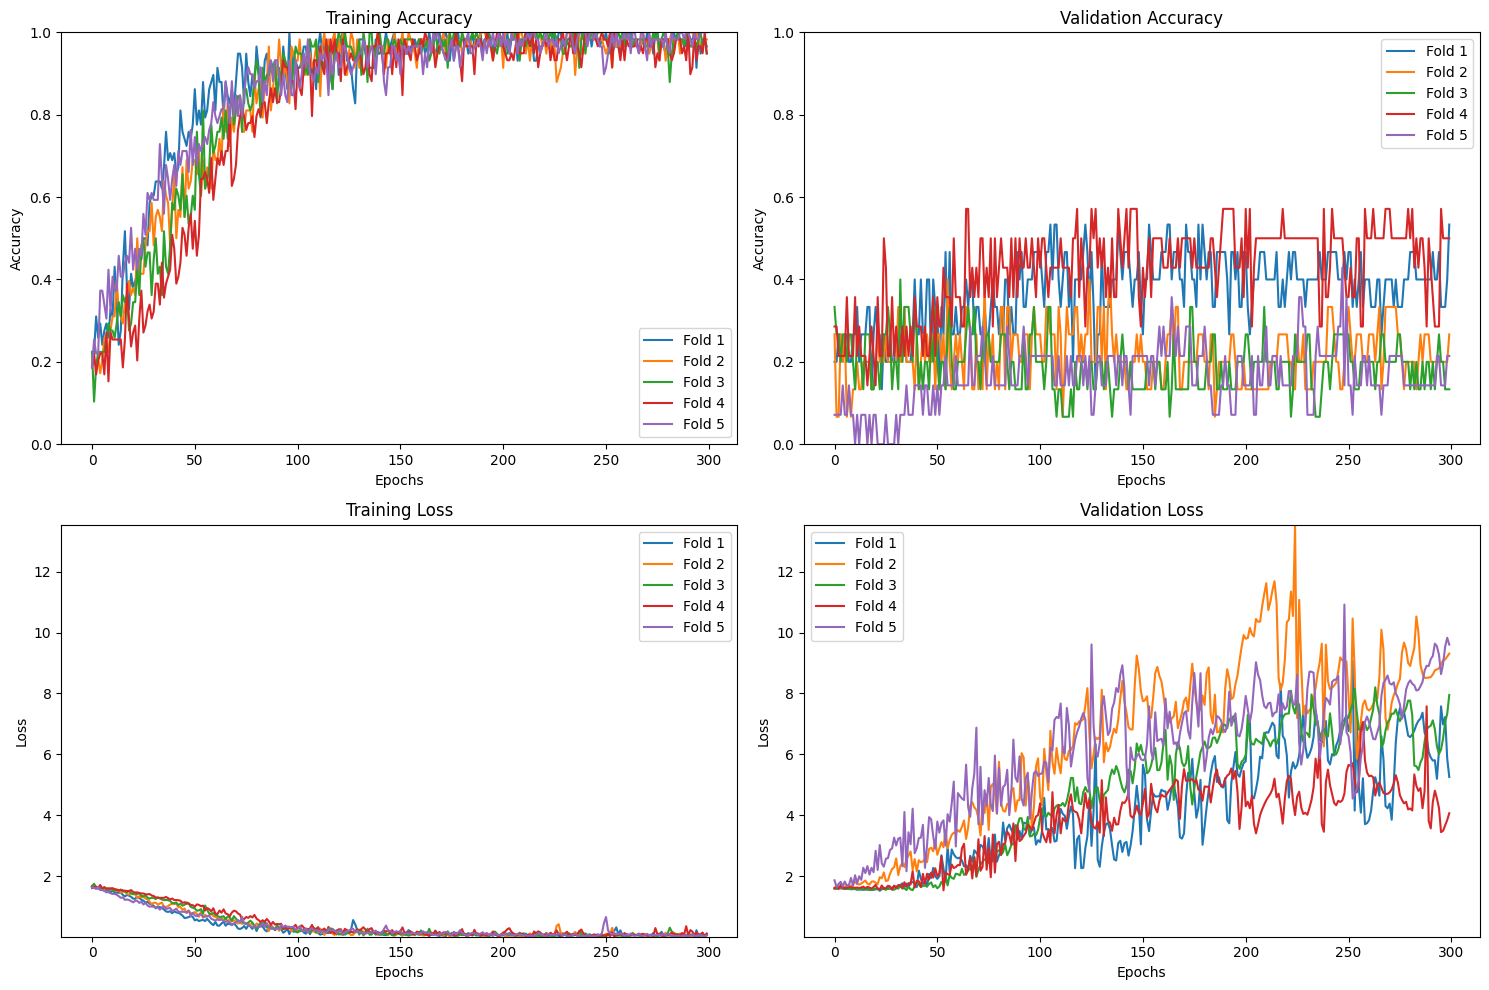

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicted classes:       [3 3 2 0 2 0 3 3 4 4 2 3 0 2]
true validation classes: [0 0 0 0 1 1 1 2 2 2 2 3 3 4]


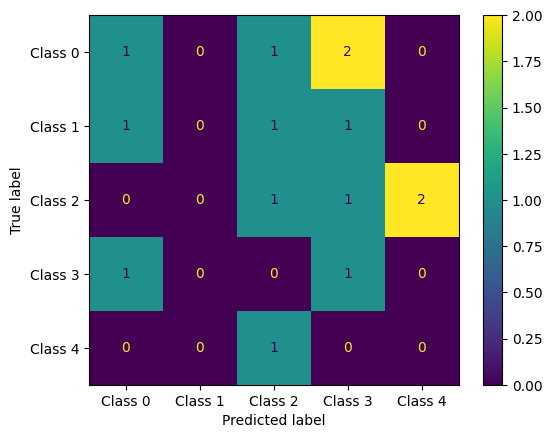

In [67]:
crossvalidate(df, model2, predictors, 'class_pond', kf, True)

As we've seen for bacteria datasets modeling differences between ponds didnt result in any good classification.

### Modeling ponds in 1 timepoint

In [72]:
df_1_tp = df[df['timepoint'] == 0]

In [73]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 256)            │     1,673,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,690,789 (6.45 MB)

 Trainable params: 1,690,789 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.4000 - loss: 1.6998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted classes:       [1 1 4 0 0]
true validation classes: [1 1 2 3 3]
mean confidence score: 1.0622, sd confidence score: 0.4091
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.7376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [1 4 1 3 2]
true validation classes: [0 1 1 3 3]
mean confidence score: 1.2836, sd confidence score: 1.1861
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.5450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [3 2 3 2 2]
true validation classes: [0 2 3 4 4]
mean confidence score: 3.2613, sd confidence score: 1.1984
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 2.3859
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predicted classes:       [3 4 1 4]
true validat

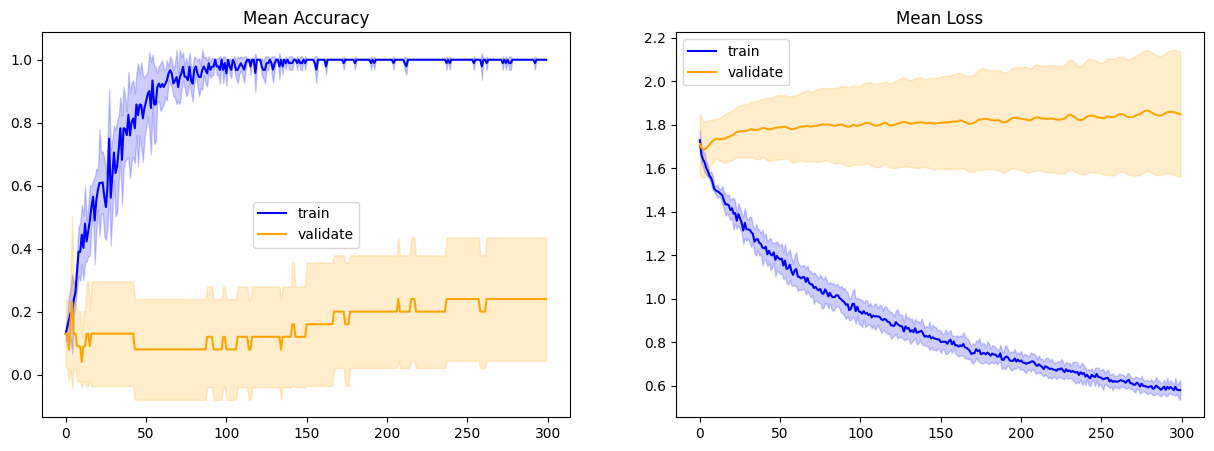

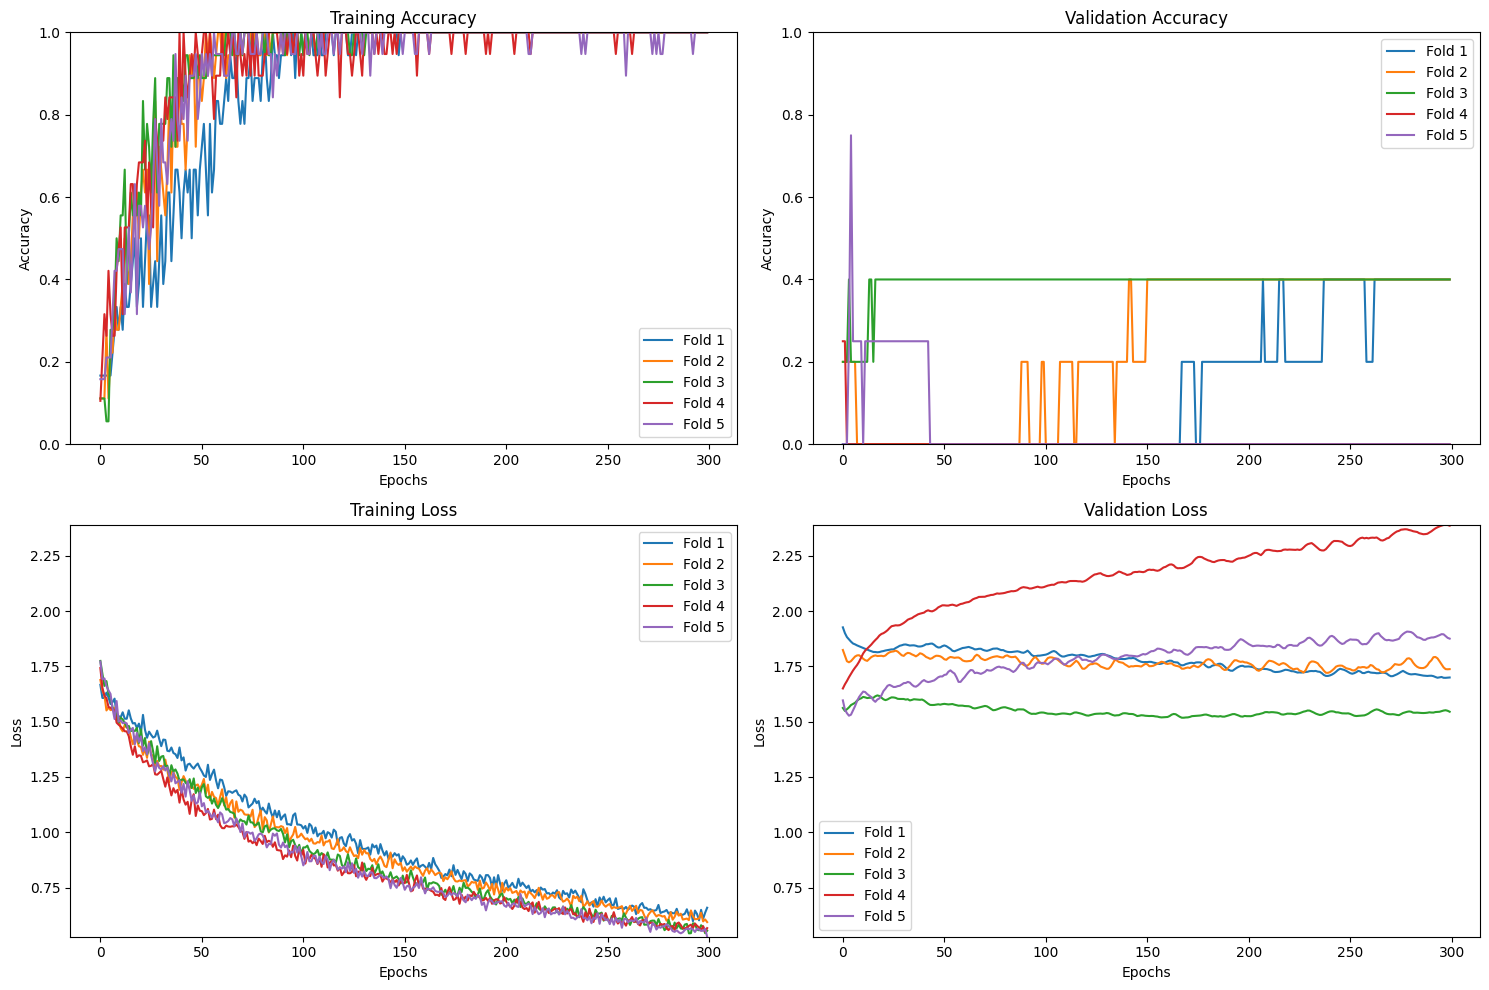

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [4 1 0 1]
true validation classes: [2 4 4 4]


ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (5).

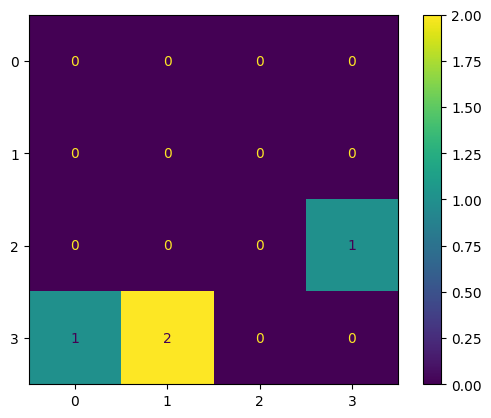

In [74]:
crossvalidate(df_1_tp, model2, predictors, 'class_pond', kf)

XXXXX

### Modeling ponds in second timepoint

In [75]:
df_2_tp = df[df['timepoint'] == 1]

In [76]:
reset_weights(model2)
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 256)            │     1,673,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,690,789 (6.45 MB)

 Trainable params: 1,690,789 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2000 - loss: 2.1072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
predicted classes:       [4 3 2 4 1]
true validation classes: [0 0 2 2 3]
mean confidence score: 1.8547, sd confidence score: 1.2361
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 2.1974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [2 4 4 0 4]
true validation classes: [1 1 2 3 3]
mean confidence score: 2.2532, sd confidence score: 0.9298
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2000 - loss: 1.6331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [2 4 4 2 4]
true validation classes: [0 0 2 3 4]
mean confidence score: 2.9379, sd confidence score: 2.4668
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 2.3701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [2 3 0 2 2]
true v

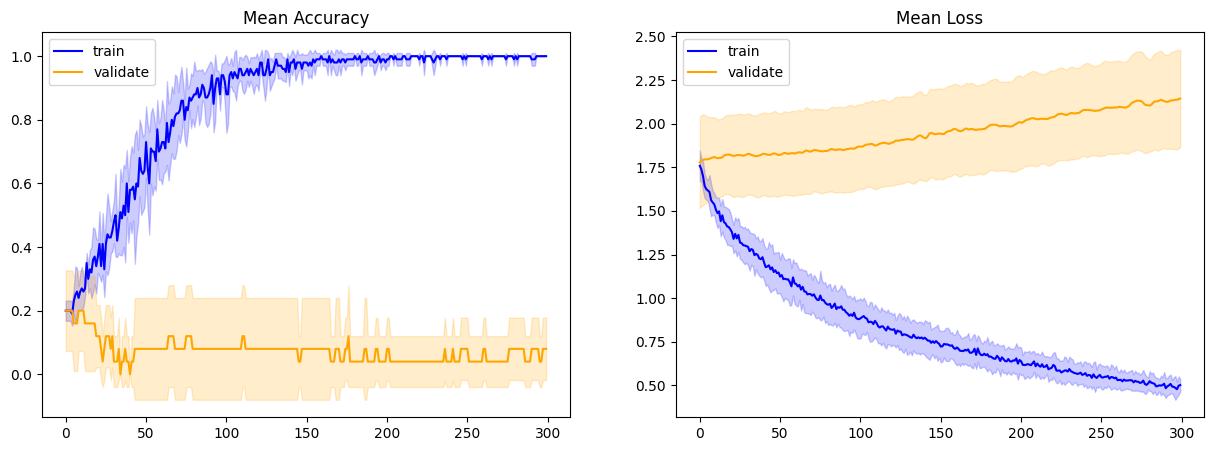

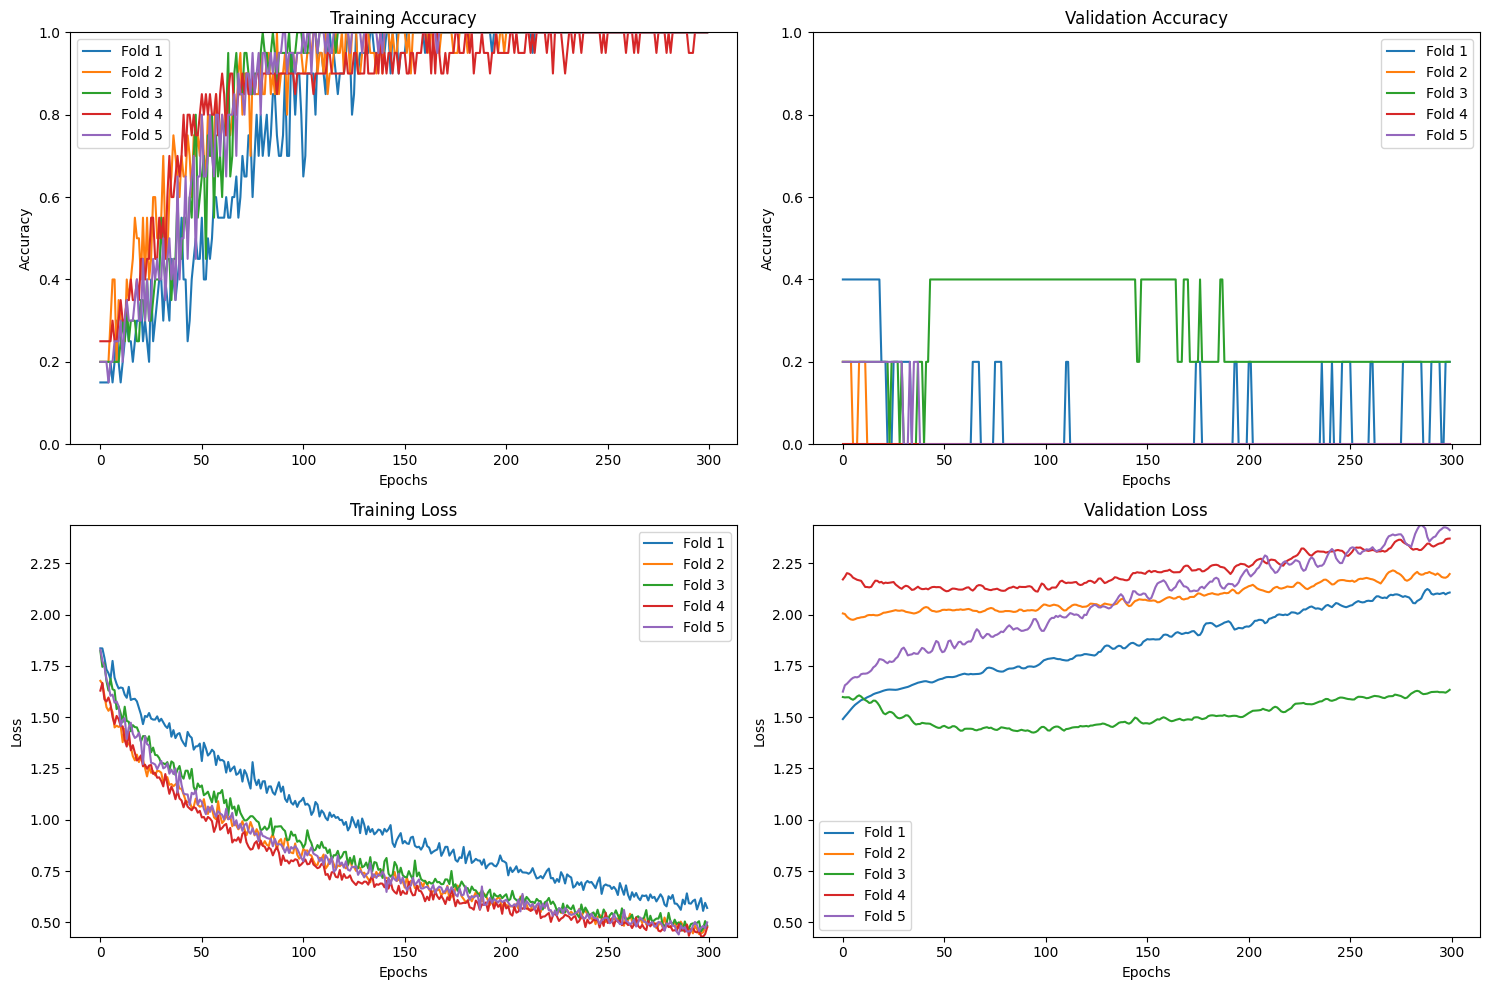

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [0 2 1 1 2]
true validation classes: [2 3 4 4 4]


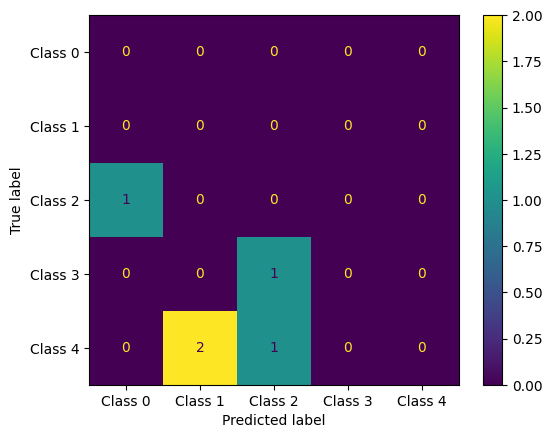

In [78]:
crossvalidate(df_2_tp, model2, predictors, 'class_pond', kf)

### Modeling ponds in third timepoint

In [80]:
df_3_tp = df[df['timepoint'] == 2]

In [81]:
reset_weights(model2)
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_47 (Dense)                │ (None, 256)            │     1,673,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,690,789 (6.45 MB)

 Trainable params: 1,690,789 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2000 - loss: 1.8475
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [3 1 0 3 3]
true validation classes: [0 0 2 2 3]
mean confidence score: 2.3364, sd confidence score: 2.17
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0000e+00 - loss: 2.3160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [3 0 4 0 4]
true validation classes: [1 1 2 3 3]
mean confidence score: 3.0554, sd confidence score: 1.5715
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 1.3645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [0 4 4 3 2]
true validation classes: [0 0 2 3 4]
mean confidence score: 3.1206, sd confidence score: 1.3023
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 2.4731
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 0 4 2 3]
true vali

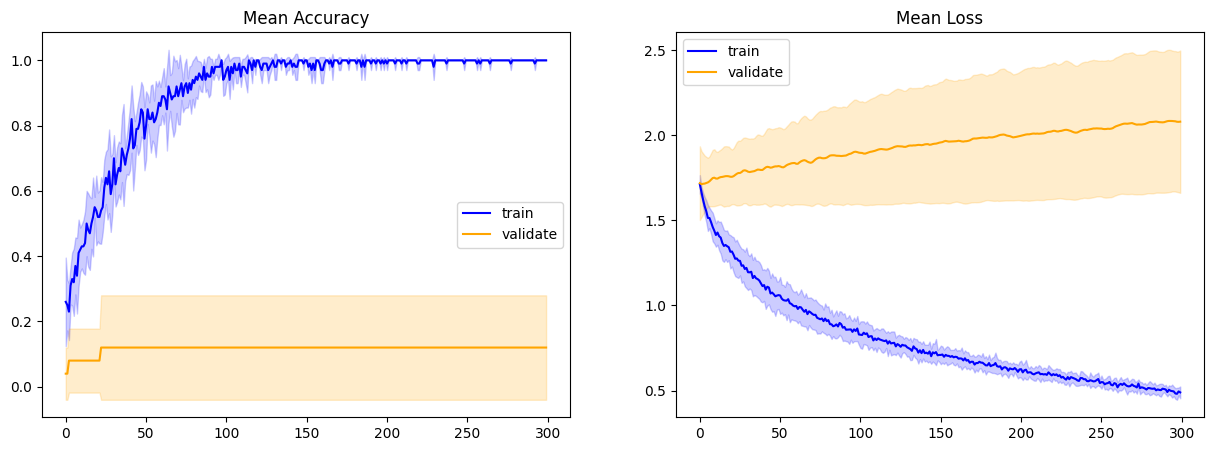

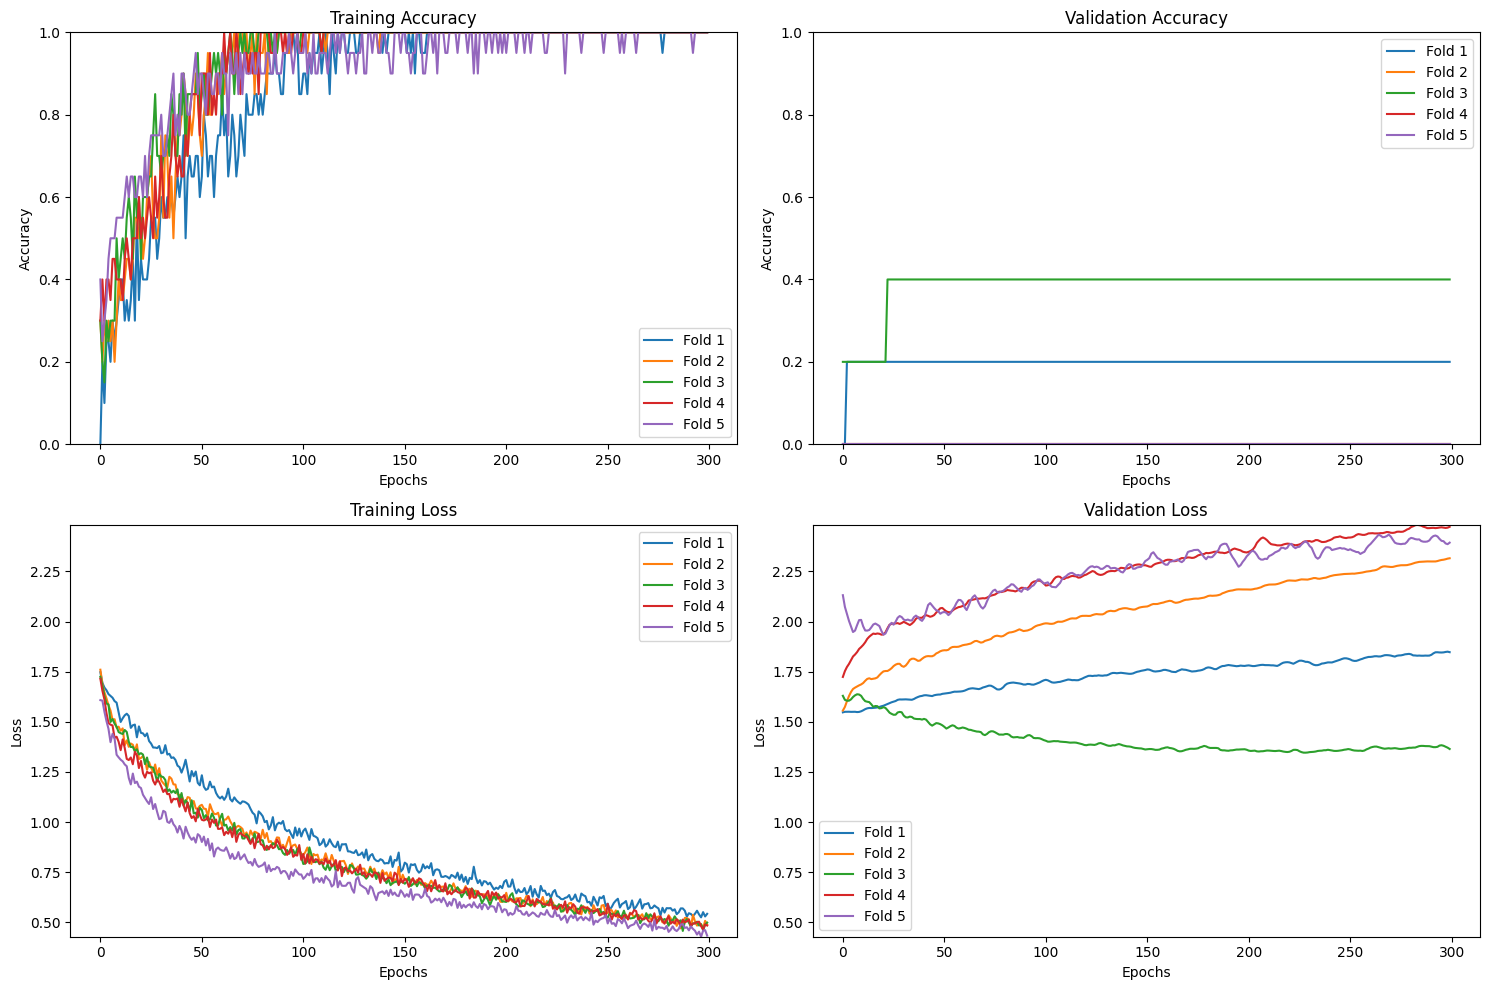

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicted classes:       [1 0 1 0 1]
true validation classes: [2 3 4 4 4]


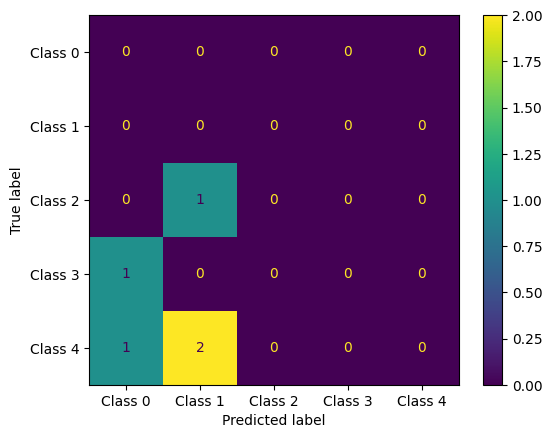

In [82]:
crossvalidate(df_3_tp, model2, predictors, 'class_pond', kf)

For both of the timepoints we were not able to classify with any satisfactionary results for any fold, this is the same case as for bacteria dataset.

## XGBoost analysis

For comparison we will replicate our analysis use XGBoost which is based on Gradient Boosting and utilising Decision trees, we could use Random forests but this prooved to be a better approach for smaller dataset and we dont require faster and better computing performance that are offered by random forests.

In [83]:

train_val_df.shape, test_df.shape

((58, 6543), (15, 6543))

In [84]:
X_train = train_val_df[predictors].values
X_test = test_df[predictors].values


### Modeling timepoints only

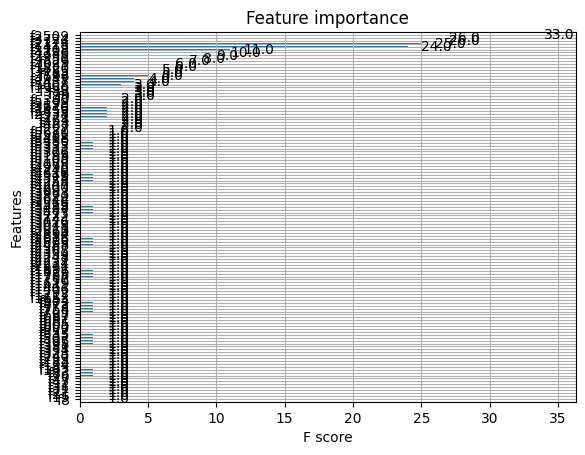

In [87]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['timepoint'])
dtest = xgb.DMatrix(X_test, label=test_df['timepoint'])
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}
bst2 = xgb.train(params, dtrain, 1000, num_boost_round=100)

xgb.plot_importance(bst2)
xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['timepoint'], xgb_pred)


[2 0 0 0 0 2 1 0 1 2 2 2 1 1 1]
[1. 0. 0. 0. 1. 1. 1. 0. 1. 2. 2. 2. 1. 1. 1.]
0.8


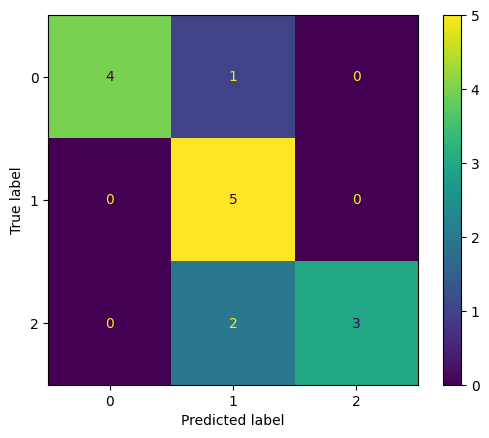

In [89]:
print(test_df['timepoint'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['timepoint'].values, xgb_pred)
ConfusionMatrixDisplay(cm).plot()

When comparing our Nerual network approach to some more robust machine learning approach as XGBoost we can see that for first analysis whchich is modeling only timepoints we have 100% accuracy, very similar to NN's

### Classifying only ponds for both timepoints

In [90]:
dtrain = xgb.DMatrix(X_train, label=train_val_df['pond'].values)  
dtest = xgb.DMatrix(X_test, label=test_df['pond'].values)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst2 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst2.predict(dtest)
xgb_acc = accuracy_score(test_df['pond'].values, xgb_pred)

ValueError: could not convert string to float: 'S19'

['S11' 'S26' 'S21' 'S11' 'S09' 'S20' 'S14' 'S08' 'S27' 'S21' 'S23' 'S18'
 'S15' 'S12' 'S30']
[1. 0. 0. 0. 1. 1. 1. 0. 1. 2. 2. 2. 1. 1. 1.]
0.8


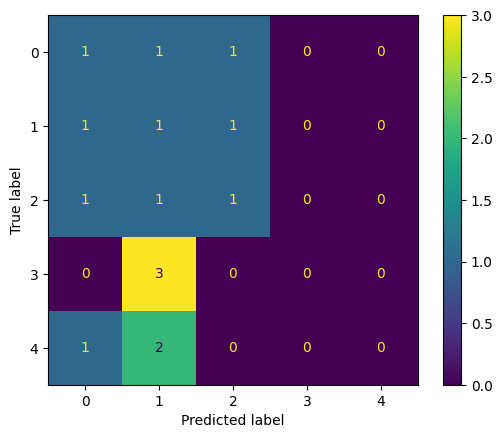

In [92]:
print(test_df['pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(test_df['class_pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

For our ponds in both timepoints at the same time we can see that the results are only slightly better - achiveing 0.5 acc in comparison to 0.3 for NN's

#### Modeling only first timepoint

In [94]:
df_first_tp = df[df['timepoint'] == 0]
print(df_first_tp.shape)
df1tp_train, df1tp_test = train_test_split(df_first_tp, test_size=10, random_state=111, stratify=df_first_tp['class_pond'])
X_2_train = df1tp_train[predictors].values
X_2_test = df1tp_test[predictors].values

(23, 6543)


In [95]:
dtrain = xgb.DMatrix(X_2_train, label=df1tp_train['pond'].values)
dtest = xgb.DMatrix(X_2_test, label=df1tp_test['pond'].values)
bst3_1 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3_1.predict(dtest)
xgb_acc = accuracy_score(df1tp_test['pond'].values, xgb_pred)

ValueError: could not convert string to float: 'S19'

In [97]:
print(df1tp_test['pond'].values)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(df1tp_test['class_pond'].values, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

['S31' 'S24' 'S11' 'S27' 'S16' 'S08' 'S28' 'S23' 'S10' 'S17']
[1. 0. 0. 0. 1. 1. 1. 0. 1. 2. 2. 2. 1. 1. 1.]
0.8


ValueError: Found input variables with inconsistent numbers of samples: [10, 15]

### Modeling only second timepoint

In [54]:
df_second_tp = df[df['timepoint'] == 1]
df_second_tp.shape

df_2tp_train, df_2tp_test = train_test_split(df_second_tp, test_size=5, random_state=111, stratify=df_second_tp['pond'])
print(df_2tp_train.shape, df_2tp_test.shape)
X_2_train = df_2tp_train[predictors].values
y_2_train = df_2tp_train['pond'].values
X_2_test = df_2tp_test[predictors].values
y_2_test = df_2tp_test['pond'].values



(20, 6373) (5, 6373)


In [55]:
dtrain = xgb.DMatrix(X_2_train, label=y_2_train)  
dtest = xgb.DMatrix(X_2_test, label=y_2_test)
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 3, # maximum deepth of the tree, used to controll complexity of the model
    'eta': 0.1,
    'seed': 111

}

bst3 = xgb.train(params, dtrain, num_boost_round=100)

xgb_pred = bst3.predict(dtest)
xgb_acc = accuracy_score(y_2_test, xgb_pred)

[2 4 1 0 3]
[3. 1. 4. 1. 2.]
0.0


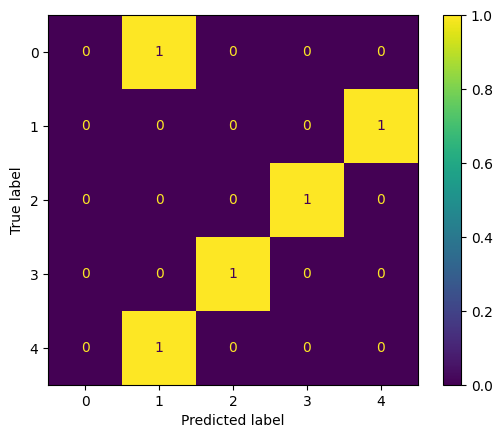

In [56]:
print(y_2_test)
print(xgb_pred)
print(xgb_acc)

cm = confusion_matrix(y_2_test, xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3,4]).plot()

For 1 timepoint where there should be more differenes from biological perspecite as it is only one week after adding supplements and micriobiome didnt have time to get back to its origianl structure we can see that xgboost algorythm managed to reach 0.6 accuracy (for 5 test samples it correctly classified 3). However for second timepoint probably because of how much time has passed we observed accuracy of 0.

### Conclusions from XGBoost
The results from the XGBoost model are slightly better especially for modeeling ponds in 1 timepoint to those obtained with neural networks, For The modelinga imed at classyifing ponds the results were bad only slightly better than for NN's this somewhat prooves that there might be not significant enough differences between ponds for the algorythm to detect.